### Analysing the change in odds on tipico.de

First we'll do the imports.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Then import the csv file, and use the parse dates argument to convert the date columns directly into datetime objects.

In [2]:
parse_dates = ['record_date', 'game_date']
df = pd.read_csv("hourly.csv", parse_dates=parse_dates)

Now we will create a dataframe for each of the individual games. So for example we might have a dataframe with 20 entries where each entry will be a record of the odds for that game at a different time.

In [3]:
list_of_df_games = []
for index, row in df.iterrows():

    # select the rows
    df_game = df.loc[(df['home_team'] == row['home_team']) & (df['away_team'] == row['away_team'])]

    # drop them from the main df 
    df = df.drop(df_game.index)

    # the data from football-data.com includes games that havent happend yet,
    # so there will be empty dataframes in our list, were going to not append them
    if not df_game.empty:
        list_of_df_games.append(df_game)

No we will create a list of the the absolute difference in the qoutes over the period of time they existed. For that we will find the min and max value of each dataframe in list_of_df_games and create a new list with them.

In [4]:
list_of_differences = []
for df_game in list_of_df_games:

    home_odds_min = float(str(df_game['home_odds'].min()).replace(',', '.'))
    home_odds_max = float(str(df_game['home_odds'].max()).replace(',', '.'))
    draw_odds_min = float(str(df_game['draw_odds'].min()).replace(',', '.'))
    draw_odds_max = float(str(df_game['draw_odds'].max()).replace(',', '.'))
    away_odds_min = float(str(df_game['away_odds'].min()).replace(',', '.'))
    away_odds_max = float(str(df_game['away_odds'].max()).replace(',', '.'))
    
    list_of_differences.append([abs(home_odds_max - home_odds_min),
                                abs(draw_odds_max - draw_odds_min),
                                abs(away_odds_max - away_odds_min)])

Lets have a little sample of the list of dataframes and the list of odds differences.

In [5]:
for i in range(5):
    print(list_of_df_games[i].head())
    print(list_of_differences[i])

           record_date           game_date    home_team          away_team  \
0  2022-08-12 05:31:25 2022-08-12 20:30:00  SC Freiburg  Borussia Dortmund   
18 2022-08-12 09:00:06 2022-08-12 20:30:00  SC Freiburg  Borussia Dortmund   
36 2022-08-12 10:00:05 2022-08-12 20:30:00  SC Freiburg  Borussia Dortmund   
54 2022-08-12 11:00:06 2022-08-12 20:30:00  SC Freiburg  Borussia Dortmund   
72 2022-08-12 12:00:05 2022-08-12 20:30:00  SC Freiburg  Borussia Dortmund   

   home_odds draw_odds away_odds over_under  over under handicap  home  draw  \
0       3,10      3,70      2,20        2,5  1,52  2,45      1:0  1,67  4,30   
18      3,00      3,70      2,25        2,5  1,55  2,40      1:0  1,65  4,30   
36      3,00      3,70      2,25        2,5  1,55  2,40      1:0  1,65  4,30   
54      3,00      3,70      2,25        2,5  1,55  2,40      1:0  1,65  4,30   
72      3,00      3,70      2,25        2,5  1,55  2,40      1:0  1,65  4,30   

    away both_teams_score_yes both_teams_score_no 

Looks like it worked correctly. No we can start the fun part and create plots. First we'll make a simple histogramm of how often each change of odds appears in the data.

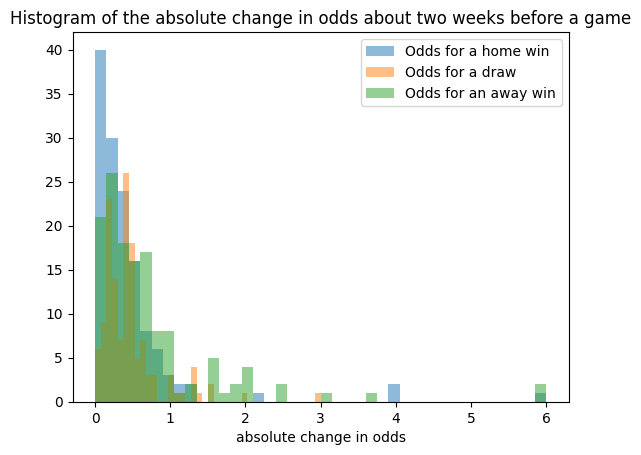

In [6]:
plt.hist([x[0] for x in list_of_differences], bins=40, label="Odds for a home win", alpha=0.5)
plt.hist([x[1] for x in list_of_differences], bins=40, label="Odds for a draw", alpha=0.5)
plt.hist([x[2] for x in list_of_differences], bins=40, label="Odds for an away win", alpha=0.5)
plt.legend(loc='upper right')
plt.title('Histogram of the absolute change in odds about two weeks before a game')
plt.xlabel('absolute change in odds')

plt.show()

The home odds seem to cange the least, while the away and draw odds change a bit more more often. Lets also see in numbers in total how often the odds change.

In [7]:
print(f"Amount of home odds that changed: {len([x[0] for x in list_of_differences if x[0] != 0.0])} / {len(list_of_differences)}")
print(f"Amount of draw odds that changed: {len([x[1] for x in list_of_differences if x[1] != 0.0])} / {len(list_of_differences)}")
print(f"Amount of away odds that changed: {len([x[2] for x in list_of_differences if x[2] != 0.0])} / {len(list_of_differences)}")

def Average(lst):
    return sum(lst) / len(lst)

print(f"Average home odd change: {Average([x[0] for x in list_of_differences])}")
print(f"Average draw odd change: {Average([x[1] for x in list_of_differences])}")
print(f"Average away odd change: {Average([x[2] for x in list_of_differences])}")

Amount of home odds that changed: 133 / 135
Amount of draw odds that changed: 129 / 135
Amount of away odds that changed: 132 / 135
Average home odd change: 0.4531851851851849
Average draw odd change: 0.46481481481481485
Average away odd change: 0.7124444444444445


Almost all odds change and the away odds change the most on average.

Bookmakers make their money by taking a commission from each bet. You can see that from looking at the odds. Invert each odd and add them up and it will be more than 1. Lets have a look:

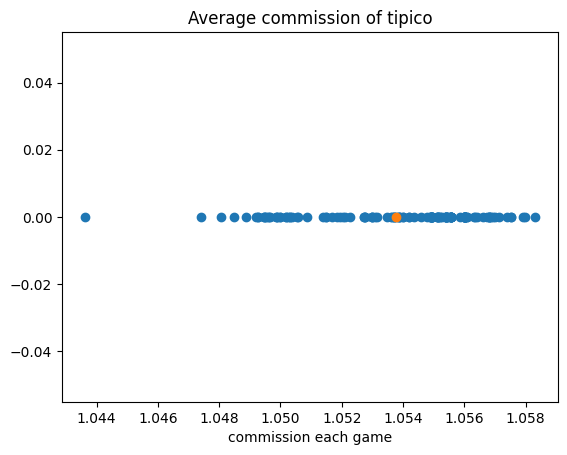

In [16]:
commission_list = []
for df_game in list_of_df_games:

    home_odd = float(df_game['home_odds'].iloc[-1].replace(',', '.'))
    draw_odd = float(df_game['draw_odds'].iloc[-1].replace(',', '.'))
    away_odd = float(df_game['away_odds'].iloc[-1].replace(',', '.'))

    commission_list.append(1/home_odd + 1/away_odd + 1/draw_odd)

plt.scatter(commission_list, [0]*len(commission_list))
plt.scatter(sum(commission_list)/len(commission_list), 0)
plt.title('Average commission of tipico')
plt.xlabel('commission each game')
plt.show()

average_commision = sum(commission_list) / len(commission_list)

The average commsion lies around 0.054, so we can roughly say tipico takes 5% comission on each bet.

Now lets examine if the change in the odds indicate anything about the outcome of the game. For that we need the outcome of each game for which we will use the data from https://www.football-data.co.uk/.

In [9]:
df_bundesliga = pd.read_csv("bundesliga_2022.csv")

# go through all the games in the previous df
for df_game in list_of_df_games:

    df_game["outcome"] = ""

    # go through all the games in the football data
    for index, row in df_bundesliga.iterrows():

        if df_game['home_team'].iloc[0] == row['HomeTeam'] and df_game['away_team'].iloc[0] == row['AwayTeam']:
            
            if row["FTHG"] > row["FTAG"]:
                df_game['outcome'] = "Home"
            elif row["FTHG"] == row["FTAG"]:
                df_game['outcome'] = "Draw"
            else:
                df_game['outcome'] = "Away"
            break

So what do we want to display using the plots? We want to see if the outcome of the game is somehow correlated to the change of odds by the bookmaker, or in other words: Does the bookmakers change of the odds reveal information about the probability of the games outcome? Idealy the bookmaker, in this case tipico, should decrease the odds if the event seems more likely, and we should see that in the data.

To answer this we will make three scatter diagramms. The first diagramm will look as follows:
On the y-Axis will be the first odd of the home team winning that was provided by tipico. On the x-Axis will be the total change in the odd of the home team winning up until the game is played. We now scatter the points, and mark them with symbols depending on how the game ended (Home win/Away win/Draw).
For each outcome (Home win/Away win/Draw) we will also scatter the average point.

In [10]:
home_list_home = []
home_list_draw = []
home_list_away = []

draw_list_home = []
draw_list_draw = []
draw_list_away = []

away_list_home = []
away_list_draw = []
away_list_away = []

for df_game in list_of_df_games:
    odd_home = float(df_game['home_odds'].iloc[0].replace(',', '.'))
    odd_draw = float(df_game['draw_odds'].iloc[0].replace(',', '.'))
    odd_away = float(df_game['away_odds'].iloc[0].replace(',', '.'))
    odd_end_home = float(df_game['home_odds'].iloc[-1].replace(',', '.'))
    odd_end_draw = float(df_game['draw_odds'].iloc[-1].replace(',', '.'))
    odd_end_away = float(df_game['away_odds'].iloc[-1].replace(',', '.'))

    if df_game['outcome'].iloc[0] == 'Home':
        home_list_home.append([odd_home - odd_end_home, odd_home])
        away_list_home.append([odd_away - odd_end_away, odd_away])
        draw_list_home.append([odd_draw - odd_end_draw, odd_draw])
    elif df_game['outcome'].iloc[0] == 'Draw':
        home_list_draw.append([odd_home - odd_end_home, odd_home])
        away_list_draw.append([odd_away - odd_end_away, odd_away])
        draw_list_draw.append([odd_draw - odd_end_draw, odd_draw])
    else:
        home_list_away.append([odd_home - odd_end_home, odd_home])
        away_list_away.append([odd_away - odd_end_away, odd_away])
        draw_list_away.append([odd_draw - odd_end_draw, odd_draw])

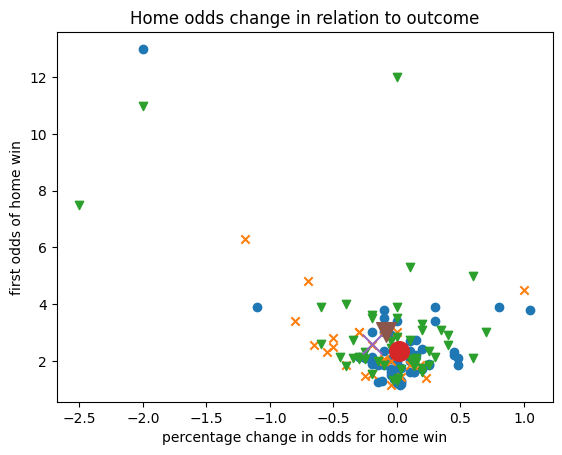

In [11]:
def average(list):
    sum0 = 0
    sum1 = 0
    for sublist in list:
        sum0 += sublist[0]
        sum1 += sublist[1]
    return [sum0 / len(list), sum1 / len(list)]

plt.scatter([item[0] for item in home_list_home], [item[1] for item in home_list_home], marker='o')
plt.scatter([item[0] for item in home_list_draw], [item[1] for item in home_list_draw], marker='x')
plt.scatter([item[0] for item in home_list_away], [item[1] for item in home_list_away], marker='v')
plt.scatter(average(home_list_home)[0], average(home_list_home)[1], marker='o', s=200)
plt.scatter(average(home_list_draw)[0], average(home_list_draw)[1], marker='x', s=200)
plt.scatter(average(home_list_away)[0], average(home_list_away)[1], marker='v', s=200)
plt.title('Home odds change in relation to outcome')
plt.xlabel('percentage change in odds for home win')
plt.ylabel('first odds of home win')

plt.show()

On average, when the home odds are decreased, which means the probability of a home win is higher, a draw and an away win are more likely to happen. Seems kind of counter intuitive. Lets remove the outliers, so everything that changed more than 1 in odds and see what happens.

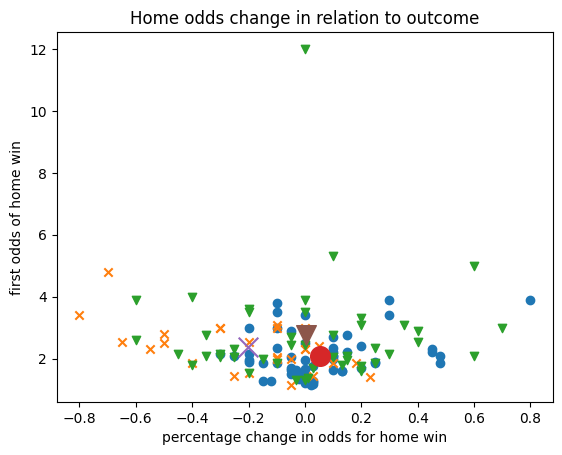

In [19]:
# if item 0 in sublist in home_list_home is more than one, remove that sublist from home_list_home
home_list_home = [item for item in home_list_home if abs(item[0]) < 1]
# same for the other lists
home_list_draw = [item for item in home_list_draw if abs(item[0]) < 1]
home_list_away = [item for item in home_list_away if abs(item[0]) < 1]

plt.scatter([item[0] for item in home_list_home], [item[1] for item in home_list_home], marker='o')
plt.scatter([item[0] for item in home_list_draw], [item[1] for item in home_list_draw], marker='x')
plt.scatter([item[0] for item in home_list_away], [item[1] for item in home_list_away], marker='v')
plt.scatter(average(home_list_home)[0], average(home_list_home)[1], marker='o', s=200)
plt.scatter(average(home_list_draw)[0], average(home_list_draw)[1], marker='x', s=200)
plt.scatter(average(home_list_away)[0], average(home_list_away)[1], marker='v', s=200)
plt.title('Home odds change in relation to outcome')
plt.xlabel('percentage change in odds for home win')
plt.ylabel('first odds of home win')

plt.show()

No we can more clearly see that the home odds definitly decrease when a draw is happening. Lets look at the away odds.

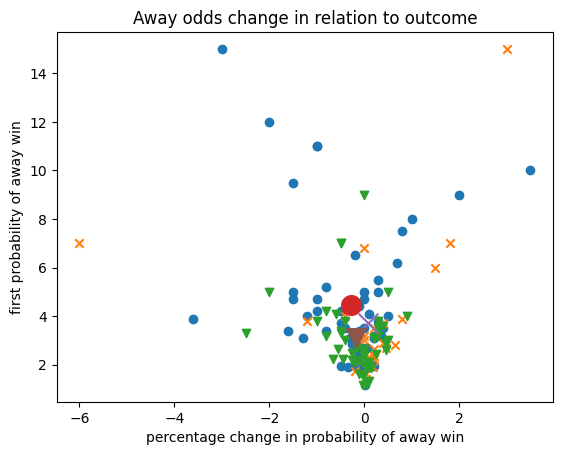

In [12]:
plt.scatter([item[0] for item in away_list_home], [item[1] for item in away_list_home], marker='o')
plt.scatter([item[0] for item in away_list_draw], [item[1] for item in away_list_draw], marker='x')
plt.scatter([item[0] for item in away_list_away], [item[1] for item in away_list_away], marker='v')
plt.scatter(average(away_list_home)[0], average(away_list_home)[1], marker='o', s=200)
plt.scatter(average(away_list_draw)[0], average(away_list_draw)[1], marker='x', s=200)
plt.scatter(average(away_list_away)[0], average(away_list_away)[1], marker='v', s=200)
plt.title('Away odds change in relation to outcome')
plt.xlabel('percentage change in probability of away win')
plt.ylabel('first probability of away win')

plt.show()

Again lets look at the away odds without the outliers.

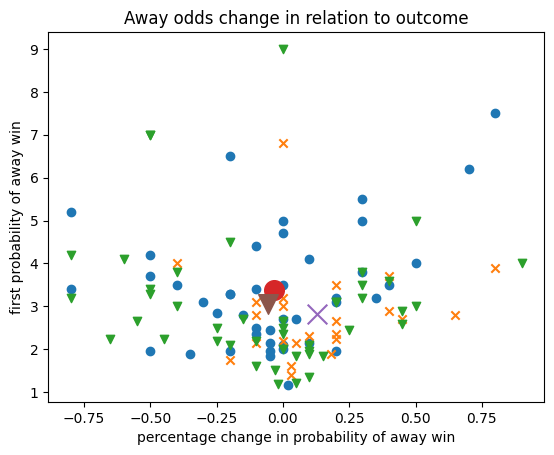

In [22]:
away_list_home = [item for item in away_list_home if abs(item[0]) < 2]
away_list_draw = [item for item in away_list_draw if abs(item[0]) < 2]
away_list_away = [item for item in away_list_away if abs(item[0]) < 2]

plt.scatter([item[0] for item in away_list_home], [item[1] for item in away_list_home], marker='o')
plt.scatter([item[0] for item in away_list_draw], [item[1] for item in away_list_draw], marker='x')
plt.scatter([item[0] for item in away_list_away], [item[1] for item in away_list_away], marker='v')
plt.scatter(average(away_list_home)[0], average(away_list_home)[1], marker='o', s=200)
plt.scatter(average(away_list_draw)[0], average(away_list_draw)[1], marker='x', s=200)
plt.scatter(average(away_list_away)[0], average(away_list_away)[1], marker='v', s=200)
plt.title('Away odds change in relation to outcome')
plt.xlabel('percentage change in probability of away win')
plt.ylabel('first probability of away win')

plt.show()

Now the draw odds:

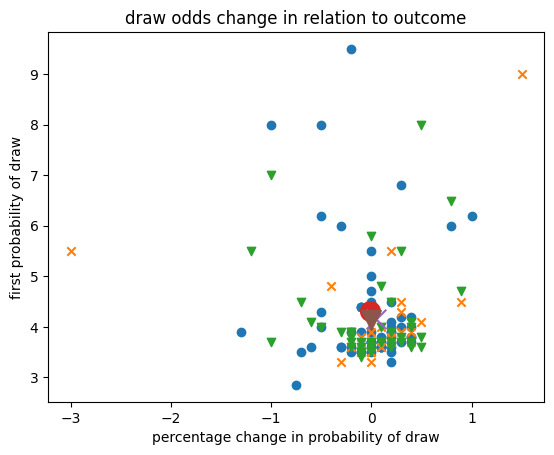

In [13]:
plt.scatter([item[0] for item in draw_list_home], [item[1] for item in draw_list_home], marker='o')
plt.scatter([item[0] for item in draw_list_draw], [item[1] for item in draw_list_draw], marker='x')
plt.scatter([item[0] for item in draw_list_away], [item[1] for item in draw_list_away], marker='v')
plt.scatter(average(draw_list_home)[0], average(draw_list_home)[1], marker='o', s=200)
plt.scatter(average(draw_list_draw)[0], average(draw_list_draw)[1], marker='x', s=200)
plt.scatter(average(draw_list_away)[0], average(draw_list_away)[1], marker='v', s=200)
plt.title('draw odds change in relation to outcome')
plt.xlabel('percentage change in probability of draw')
plt.ylabel('first probability of draw')

plt.show()

Well, the change in the draw odds dont seem to have an effect on anything.